## Scene Hierarchy

In [21]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [22]:
# Check if CUDA is available on this machine
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA not available. Training on CPU.')
else:
    print('CUDA available. Training on GPU.')

CUDA available. Training on GPU.


In [23]:
# Define train and test data directories
data_dir = 'images/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')
val_dir = os.path.join(data_dir, 'val/')

classes = ['coast', 'forest', 'highway', 'insidecity', 'mountain',
          'opencountry', 'street', 'tallbuilding']

In [24]:
# Load and transform data using ImageFolder

# Resize image as VGG16 takes 224x224 images as input
data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)

In [25]:
# Define DataLoader parameters
BATCH_SIZE = 20
NUM_WORKERS = 0

# prepare DataLoaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS, drop_last=True,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS, drop_last=True,)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS)


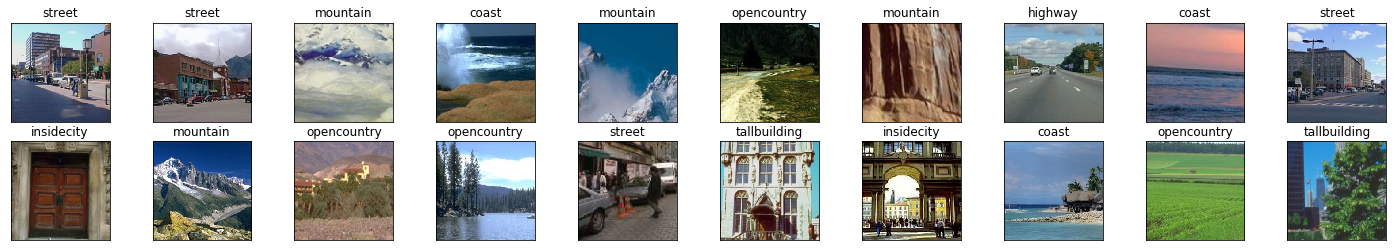

In [26]:
# Visualize one batch of sample training data
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# Plot the images in one batch with corresponding labels
fig = plt.figure(figsize=(25,4))

for idx in range(BATCH_SIZE):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1,2,0)))
    ax.set_title(classes[labels[idx]])

In [27]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False
    
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [28]:
# Modify the final layer
import torch.nn as nn

n_inputs = vgg16.classifier[6].in_features

# Edit last linear layer, n_inputs to 8 scene classes
# New layers automatcially have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

if train_on_gpu:
    vgg16.cuda()

# Verify last layer amended accordingly 
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

## Load the Saved Model
In order to load model using __load_state_dict__ ensure that the model has the same NN architecture structure as __load_state_dict__

In [29]:
vgg16.load_state_dict(torch.load('vgg16_scene.pt'))
# vgg16 = torch.load('vgg16_scene_full.pt')

In [30]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

## Testing the Model

In [31]:
# track test loss over all classes
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

vgg16.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(BATCH_SIZE):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.323991

Test Accuracy of coast: 88% (30/34)
Test Accuracy of forest: 90% (28/31)
Test Accuracy of highway: 76% (19/25)
Test Accuracy of insidecity: 86% (25/29)
Test Accuracy of mountain: 91% (33/36)
Test Accuracy of opencountry: 79% (31/39)
Test Accuracy of street: 89% (25/28)
Test Accuracy of tallbuilding: 100% (18/18)

Test Accuracy (Overall): 87% (209/240)


## Visualize the data
The last 4 layers of the VGG16 classifier is removed to create a feature extractor with a length of 4096. The 4096 dimmensions are then reduced to 2D utilising t-SNE.

In [32]:
from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

from sklearn.manifold import TSNE

In [33]:
vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children())[:3])
print(vgg16)

feature_vector_list = []
labels_list = []
target_list = []
data_list = []

for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        
    output = vgg16(data)
    last_layer = output.cpu().detach().numpy()
    labels = target.cpu().detach().numpy()
    
    for i in range(BATCH_SIZE):
        feature_vector_list.append(last_layer[i])
        labels_list.append(labels[i])
        data_list.append(data[i])
        
tsne = TSNE(perplexity=10, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(feature_vector_list)
# Convert to numpy array
low_dim_embs = np.array(low_dim_embs)
labels_list = np.array(labels_list)
data_list = np.array(data_list)
    

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

## Visualization of the Model

In [34]:
OFFSET = 5
def low_dimm_visualization(low_dimm_weights, labels, status='points'):
    """ takes in an array of coordinates and its corresponding label
        and returns a graph showing visualising the data.
    """
    figure(num=None, figsize=(8,6), dpi=80)    
    # Clear current axis
    plt.cla()
    X, Y = low_dimm_weights[:,0], low_dimm_weights[:,1]
    colors = []
    for label in labels:
        c = cm.rainbow(int(255 * label / len(classes)))
        colors.append(c)
    
    # Plot scatter graph
    plt.scatter(X, Y, c=colors, label=colors)
    plt.xlim(X.min() - OFFSET, X.max() + OFFSET)
    plt.ylim(Y.min() - OFFSET, Y.max() + OFFSET)
    plt.title('Low Dimmension Visualization')
    
    # Plot the legend
    rects = []

    for i in range(len(classes)):
        c = cm.rainbow(int(255 * i / len(classes)))
        rects.append(mpatches.Rectangle((0,0), 1, 1, fc=c))
    # Parameter ncol: number of columns
    plt.legend(rects, classes, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

##  Low dimensional display of scene images

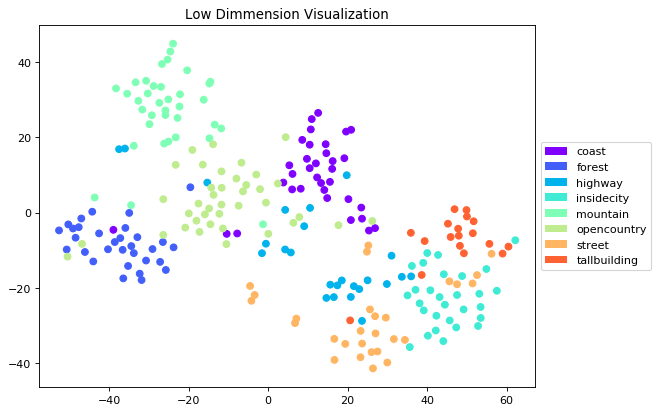

In [35]:
low_dimm_visualization(low_dim_embs, labels_list)


## Outliers Rejection
A density-based clustering algorithm, HDBSCAN (Hierachical Density-Based Spatial Clustering of Applications of Noise) is used to detect outliers. 

In order to detect outliers accurately, HDBSCAN is performed individually on each class.

In [36]:
import hdbscan
import numpy as np
import pandas as pd

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

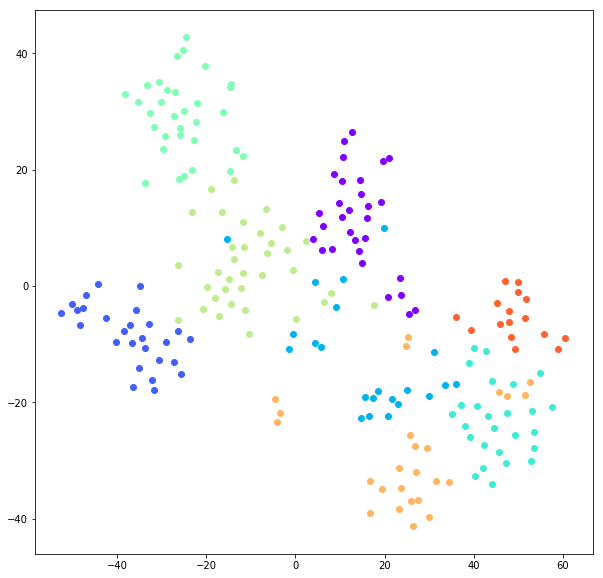

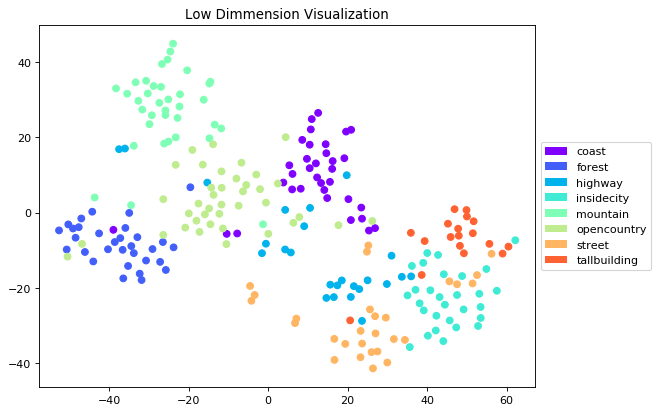

In [37]:
# Seperate each scene class
low_dim_embs_dict = {}
fig, ax = plt.subplots(figsize=(10, 10))

for i in range(len(classes)):
    low_dim_embs_dict[i] = []

for i in range(len(low_dim_embs)):
    low_dim_embs_dict[labels_list[i]].append(low_dim_embs[i].tolist())    
outliers_list = []
total_points = 0
for i in range(len(low_dim_embs_dict)):
    y = np.array(low_dim_embs_dict[i])
    
    cluster = hdbscan.HDBSCAN(min_cluster_size=2)
    cluster.fit(y)
    threshold = pd.Series(cluster.outlier_scores_).quantile(0.9)
    outliers = np.where(cluster.outlier_scores_ > threshold)[0]
    points = np.where(cluster.outlier_scores_ < threshold)[0]
    
    # Simple display
    outlier_points = y[outliers]
    outliers_list += outlier_points.tolist()
    display_points = y[points]
    total_points += len(display_points)
    X, Y = display_points[:, 0], display_points[:, 1]
    c = cm.rainbow(int(255 * i / len(classes)))
    ax.scatter(X,Y, c=c)

low_dimm_visualization(low_dim_embs, labels_list)



## Remove outliers from low_dim_embs

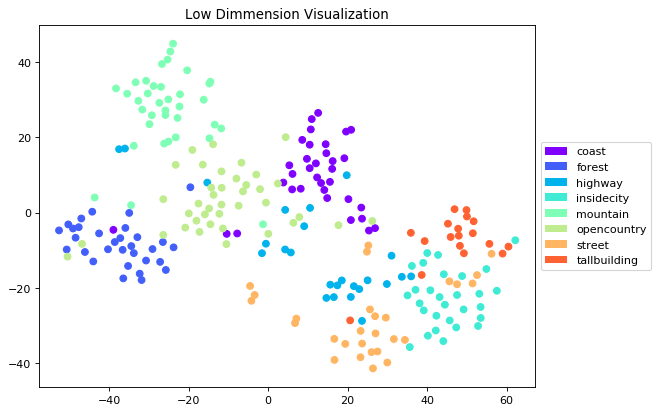

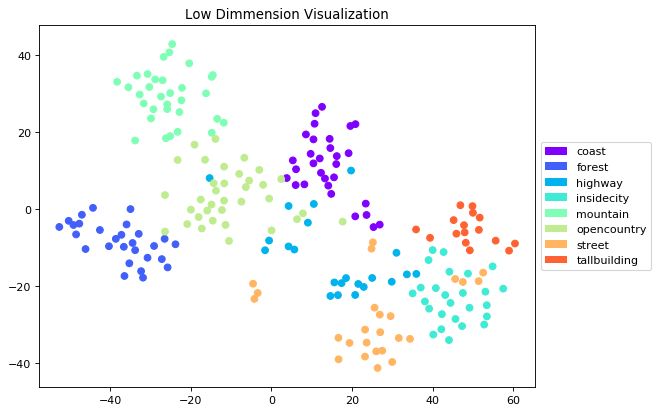

In [38]:
outliers_list = np.array(outliers_list)

idx_list = []
for step, low_dim_emb in enumerate(low_dim_embs):
    for out in outliers_list:
        if low_dim_emb[0] == out[0] and low_dim_emb[1] == out[1]:
            idx_list.append(step)

# Update values by removing indexes from idx_list (remove outliers)
low_dim_embs_updated = np.delete(low_dim_embs, idx_list, axis = 0)
labels_list_updated = np.delete(labels_list, idx_list)
data_list_updated = np.delete(data_list, idx_list)
low_dimm_visualization(low_dim_embs, labels_list)
low_dimm_visualization(low_dim_embs_updated, labels_list_updated)


## Replace Scatter points with Actual Images
Provide a rough visualisation of the scene hierachy by substituting updated points with its corresponding image

Total Points: 240


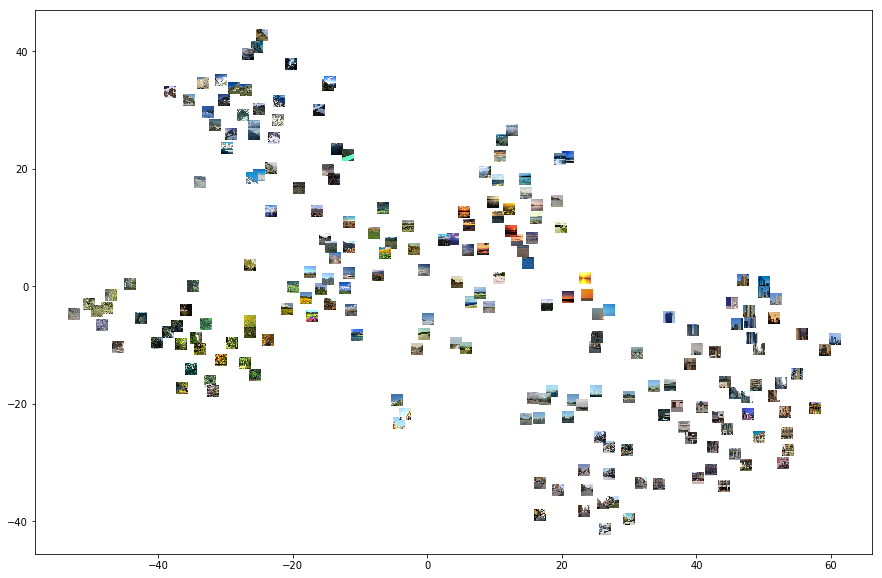

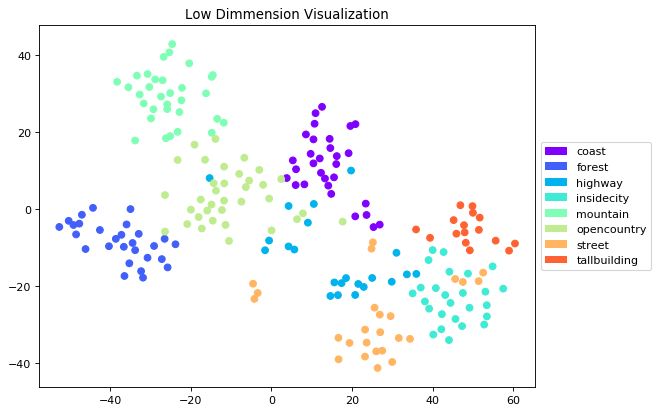

In [39]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig, ax = plt.subplots(figsize=(15, 10))

X, Y = low_dim_embs_updated[:, 0], low_dim_embs_updated[:, 1]

# Get color based on label value
colors = []
for label in labels_list_updated:
    c = cm.rainbow(int(255 * label / len(classes)))
    colors.append(c)
ax.scatter(X,Y,c=colors)


x, y = low_dim_embs_updated[:, 0], low_dim_embs_updated[:, 1]
x_max = max(x)
y_max = max(y)
x_min = min(x)
y_min = min(y)
for x0, y0, d in zip(x, y,data_list_updated):
    d = d.cpu().numpy()
    im = np.transpose(d, (1, 2, 0))
    ab = AnnotationBbox(OffsetImage(im, zoom=0.05), (x0, y0), frameon=False)
    ax.add_artist(ab)  
    
print('Total Points:', len(data_list))

low_dimm_visualization(low_dim_embs_updated, labels_list_updated)
  

## Refitting Images into a Grid for better visualization
Images will be fitted into a grid to provide better visualisation for scene hierachy

In [40]:
from PIL import Image
import cv2

IMAGE_SIZE = 100

X, Y = low_dim_embs_updated[:, 0], low_dim_embs_updated[:, 1]
rows = int((x_max + abs(x_min)) * IMAGE_SIZE)
cols = int((y_max + abs(y_min)) * IMAGE_SIZE)

placeholder = Image.new('RGB', (rows,cols))

for x, y, d in zip(X,Y,data_list_updated):
    # Convert pytorch tensor to opencv numpy image
    im = np.transpose(d.cpu().numpy(), (1, 2, 0))
    im = cv2.resize(im, (IMAGE_SIZE,IMAGE_SIZE))
    # Convert opencv numpy image to PIL image
    im = (im * 255).astype(np.uint8)
    im = Image.fromarray(im)
    x = int(x + abs(x_min)) * IMAGE_SIZE
    y = int(y + abs(y_min)) * IMAGE_SIZE
    placeholder.paste(im, (x,y))

placeholder.save('scene_heirarchy.jpg')

## Display Image

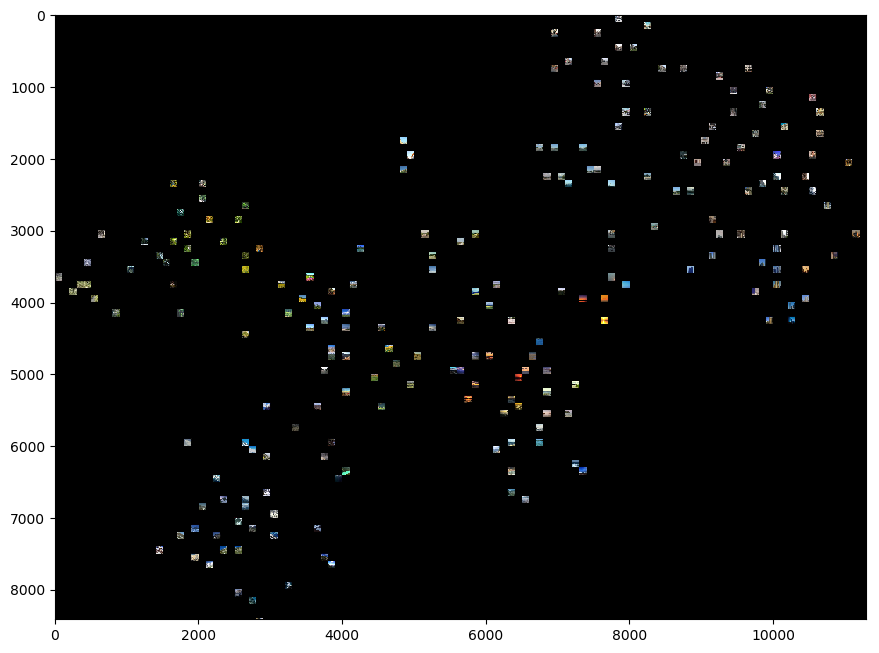

In [44]:
import matplotlib.image as mpimg

figure(num=None, figsize=(16, 8), dpi=100, facecolor='w', edgecolor='k')
im = mpimg.imread('scene_heirarchy.jpg')
plt.imshow(im)